In [1]:
import sys
print('Python {}'.format(sys.version))

Python 3.7.0 (default, Oct  7 2018, 13:03:13) 
[GCC 7.3.0]


In [2]:
# attach to crossbar event store
import zlmdb
from cfxdb.schema import Schema

# when running notebook inside docker
DBFILE = '../testdb'

# when running notebook directly on host
DBFILE = '../../crossbar/.testdb'

db = zlmdb.Database(DBFILE, maxsize=2**30, readonly=True)

schema = Schema.attach(db)

print(db)

In [3]:
vec_x = []
vec_y = []
vec_category = []
vec_value2 = []

map_categories = {'null': 0, 'alert': 1, 'warning': 2, 'info': 3, 'ad': 4, 'other': 5}

with db.begin() as txn:
    i = 0
    # query event store and get geo events ..
    for evt in schema.publications.select(txn, limit=1000000-1, return_keys=False):
        if evt.topic.startswith('com.example.geoservice.'):
            e = evt.args[0]
            vec_x.append(e['x'])
            vec_y.append(e['y'])
            vec_category.append(map_categories.get(e['category'], 0))
            vec_value2.append(e['value2'])
        i += 1
        if i % 10000 == 0:
            print('processed {} records ..'.format(i))

print('finished: collected vectors of length {}'.format(len(vec_x)))

processed 10000 records ..
processed 20000 records ..
processed 30000 records ..
processed 40000 records ..
processed 50000 records ..
finished: collected vectors of length 54329


In [4]:
import numpy as np
import pandas as pd

# create pandas dataframe from data collected in lists
df = pd.DataFrame({
    'x': np.asarray(vec_x, dtype='uint16'),
    'y': np.asarray(vec_y, dtype='uint16'),
    'category': np.asarray(vec_category, dtype='uint8'),
    'value2': np.asarray(vec_value2, dtype='float32')
})

# compute some basic statistics
df.describe()

,x,y,category,value2
count,54329.000000,54329.000000,54329.000000,54329.000000
mean,50.030315,49.924442,3.004878,0.501813
std,29.215132,29.066145,1.416553,0.288219
min,0.000000,0.000000,1.000000,0.000008
25%,25.000000,25.000000,2.000000,0.251303
50%,50.000000,50.000000,3.000000,0.503480
75%,75.000000,75.000000,4.000000,0.752717
max,100.000000,100.000000,5.000000,0.999982


/home/oberstet/cpy370_1/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


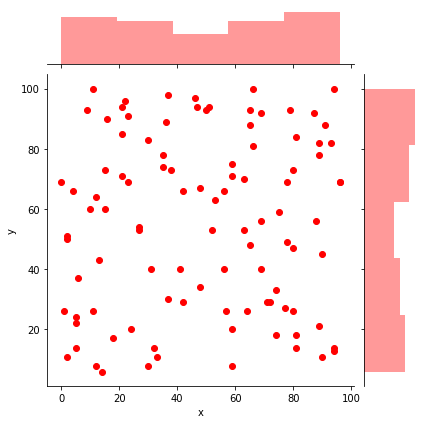

In [5]:
%matplotlib inline

import seaborn as sns

# scatterplot of the first 100 data points
sns.jointplot(data=df[:100], x='x', y='y', kind='scatter', color='r')

In [6]:
# compute truncated dataset
import math

def trunc(val):
    return int(val / 20)

df3 = pd.DataFrame({
    'x': df['x'].apply(trunc),
    'y': df['y'].apply(trunc),
    'value': df['value2'],
})

# compute aggregate
df4 = df3.pivot_table(index='x', columns='y', values='value', aggfunc=np.median)

df4

y,0,1,2,3,4,5
x,,,,,,
0,0.501208,0.509216,0.513635,0.479069,0.500698,0.516006
1,0.505820,0.499166,0.511938,0.526053,0.512123,0.521450
2,0.499674,0.510251,0.497012,0.501565,0.483123,0.531975
3,0.500024,0.503853,0.502365,0.512313,0.496125,0.566534
4,0.495139,0.515034,0.494750,0.497092,0.504172,0.540792
5,0.572624,0.459266,0.479113,0.578355,0.523372,0.299809


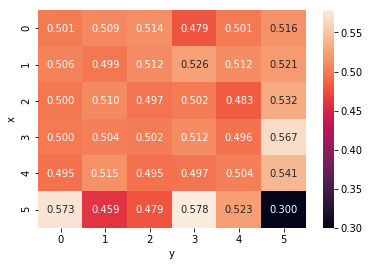

In [7]:
# plot heatmap of truncated/aggregated data
sns.heatmap(df4, annot=True, fmt=".3f")